# 🚀 Building Custom Language Models: From Raw Data to Production AI

In today's rapidly evolving AI landscape, the ability to create custom language models tailored to specific domains represents a **critical competitive advantage**. This comprehensive guide walks you through the complete lifecycle of building language models—from curating high-quality datasets to training and deploying powerful AI systems that deliver real business value.

Whether you're developing specialized models for healthcare, finance, legal services, or any domain requiring nuanced understanding, this notebook provides the **practical knowledge and code examples** you need to succeed. We'll explore modern techniques using the Hugging Face ecosystem that balance efficiency, scalability, and model quality.

## 📑 Table of Contents

1. [Environment Setup](#environment-setup)
2. [Dataset Curation Fundamentals](#dataset-curation)
3. [Text Cleaning and Processing](#text-cleaning)
4. [Bias Detection and Mitigation](#bias-detection)
5. [Custom Tokenizer Training](#tokenizer-training)
6. [Scalable Data Processing](#scalable-processing)
7. [Model Configuration and Initialization](#model-configuration)
8. [Parameter-Efficient Fine-Tuning](#peft)
9. [Training and Monitoring](#training)
10. [Error Analysis and Iteration](#error-analysis)

## 📋 What You'll Master

- **Data curation fundamentals**: selecting, cleaning, and preparing domain-specific text
- **Scalable processing techniques** for handling massive datasets efficiently  
- **Privacy protection and data versioning** for responsible AI development
- **Modern model architecture selection** and configuration strategies
- **Training workflows** with distributed computing and experiment tracking
- **Parameter-efficient fine-tuning methods** for adapting large models
- **Evaluation, error analysis**, and iterative improvement techniques

## 🛠️ Environment Setup <a id='environment-setup'></a>

Let's start by setting up our environment with all the necessary libraries. We'll use the latest versions of the Hugging Face ecosystem tools.

### 📋 Prerequisites

1. **Python 3.12.9** - Required for consistency with the project's Poetry lock file
2. **Poetry** - For dependency management
3. **API Keys** (optional) - For external services

### 🔐 API Key Configuration

Before running examples that require external APIs, create a `.env` file:

```bash
# Copy the example environment file
cp .env.example .env

# Edit .env and add your actual API keys:
# - OPENAI_API_KEY (optional - for OpenAI examples)
# - ANTHROPIC_API_KEY (optional - for Claude examples)  
# - HUGGINGFACE_TOKEN (optional - for private model access)
```

⚠️ **Important**: Make sure your API keys are actual values, not placeholders like "your-api-key-here"

### ⚡ Important Dependencies

- **accelerate>=0.26.0** - Required version for compatibility with model configurations
- **bitsandbytes** - Note: Shows warnings on macOS (Metal/MPS not supported, falls back to CPU)

### 📦 Installation

```bash
# Using Poetry (recommended)
poetry install

# Or install specific requirements
poetry add accelerate@^0.26.0
```

In [1]:
# Core imports
import os
import re
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Validate API keys (optional)
def validate_api_key(key_name: str, key_value: Optional[str]) -> bool:
    """Validate an API key is set and not a placeholder."""
    if not key_value or key_value.strip() == "":
        print(f"⚠️ {key_name} not found in environment variables")
        return False
    if key_value.lower() in ["your-api-key-here", "placeholder", "xxx", "todo"]:
        print(f"⚠️ {key_name} contains a placeholder value")
        return False
    return True

# Check API keys
api_keys = {
    "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY"),
    "ANTHROPIC_API_KEY": os.getenv("ANTHROPIC_API_KEY"),
    "HUGGINGFACE_TOKEN": os.getenv("HUGGINGFACE_TOKEN")
}

print("API Key Status:")
for key_name, key_value in api_keys.items():
    status = "✅ Set" if validate_api_key(key_name, key_value) else "❌ Not set"
    print(f"  {key_name}: {status}")

# Hugging Face ecosystem
try:
    from datasets import load_dataset, Dataset, DatasetDict
    print("\n✅ datasets library loaded successfully")
except ImportError as e:
    print(f"\n❌ Error loading datasets: {e}")

from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    AutoConfig,
    GPT2Config, 
    GPT2LMHeadModel,
    PreTrainedTokenizerFast,
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback,
    BitsAndBytesConfig
)
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

try:
    from peft import LoraConfig, get_peft_model, TaskType
    print("✅ PEFT library loaded successfully")
except ImportError:
    print("❌ PEFT library not available - LoRA examples will be skipped")

# Utility imports
import torch
from tqdm.auto import tqdm
import unicodedata

# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️ Using device: {device}")
print(f"📦 PyTorch version: {torch.__version__}")

import transformers
print(f"📦 Transformers version: {transformers.__version__}")

# Suppress bitsandbytes warnings on macOS
if device.type == "cpu":
    os.environ["BITSANDBYTES_NOWELCOME"] = "1"

API Key Status:
⚠️ OPENAI_API_KEY not found in environment variables
  OPENAI_API_KEY: ❌ Not set
⚠️ ANTHROPIC_API_KEY not found in environment variables
  ANTHROPIC_API_KEY: ❌ Not set
⚠️ HUGGINGFACE_TOKEN not found in environment variables
  HUGGINGFACE_TOKEN: ❌ Not set

✅ datasets library loaded successfully


W0728 14:31:14.174000 81069 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


✅ PEFT library loaded successfully

🖥️ Using device: cpu
📦 PyTorch version: 2.7.1
📦 Transformers version: 4.39.3


## 🧠 Dataset Curation and Training Language Models from Scratch <a id='dataset-curation'></a>

To build a great language model, you need great data. Let's visualize the complete pipeline from raw data to a production-ready model:

```mermaid
mindmap
  root((Dataset Curation & Training LLMs))
    Data Quality Foundation
      Source Selection
      Cleaning & Deduplication
      Labeling & Annotation
      Domain Relevance
    Modern Processing
      Streaming & Batching
      Cloud Integration
      Privacy & Compliance
      Versioning & Reproducibility
    Model Configuration
      Architecture Selection
      Parameter-Efficient Methods
      Pre-trained vs Scratch
      Distributed Training
    Training Workflow
      Monitoring & Metrics
      Early Stopping
      Checkpointing
      Iterative Improvement
    Production Ready
      Experiment Tracking
      Error Analysis
      Human-in-the-Loop
      Deployment Pipeline
```

### 🎯 Why Data Quality Matters

"Garbage in, garbage out" remains a core truth in AI. If your dataset contains messy, biased, or irrelevant content, your model will reflect those flaws with painful accuracy. Let's start with a practical example of loading and examining data.

In [2]:
# Load a small sample dataset for demonstration
# In production, you'd load your domain-specific data
sample_data = {
    "text": [
        "The patient presented with acute myocardial infarction and was treated with aspirin.",
        "<p>Click here for more info!</p> Visit our website at https://example.com",
        "The quarterly earnings report shows a 15% increase in revenue.",
        "Contact Dr. Smith at dr.smith@hospital.com or call 555-123-4567.",
        "The    text   has    too    many     spaces     and\n\nnewlines."
    ],
    "domain": ["medical", "web", "financial", "medical", "general"]
}

# Create a dataset
raw_dataset = Dataset.from_dict(sample_data)
print(f"Dataset size: {len(raw_dataset)} examples")
print(f"\nFirst example:")
print(raw_dataset[0])

Dataset size: 5 examples

First example:
{'text': 'The patient presented with acute myocardial infarction and was treated with aspirin.', 'domain': 'medical'}


## 🧽 Text Cleaning and Processing <a id='text-cleaning'></a>

Clean data is the foundation of any successful language model. Let's implement a comprehensive text cleaning pipeline that handles common issues:

In [3]:
def clean_text(example: Dict[str, str]) -> Dict[str, str]:
    """
    Comprehensive text cleaning function that handles:
    - Unicode normalization
    - HTML tag removal
    - URL removal
    - Whitespace normalization
    
    Args:
        example: Dictionary with 'text' key
        
    Returns:
        Dictionary with cleaned 'text' and preserved metadata
    """
    try:
        text = example["text"]
        
        # Unicode normalization
        text = unicodedata.normalize('NFKC', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove URLs
        text = re.sub(r'https?://\S+', '', text)
        
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        
        # Strip leading/trailing whitespace
        text = text.strip()
        
        return {"text": text, "domain": example.get("domain", "unknown")}
    
    except KeyError as e:
        print(f"Error: Missing required key {e}")
        return example
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return example

# Apply cleaning to our dataset
cleaned_dataset = raw_dataset.map(clean_text)

# Compare before and after
print("BEFORE CLEANING:")
for i in range(min(3, len(raw_dataset))):
    print(f"{i}: {raw_dataset[i]['text'][:100]}...")

print("\nAFTER CLEANING:")
for i in range(min(3, len(cleaned_dataset))):
    print(f"{i}: {cleaned_dataset[i]['text'][:100]}...")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

BEFORE CLEANING:
0: The patient presented with acute myocardial infarction and was treated with aspirin....
1: <p>Click here for more info!</p> Visit our website at https://example.com...
2: The quarterly earnings report shows a 15% increase in revenue....

AFTER CLEANING:
0: The patient presented with acute myocardial infarction and was treated with aspirin....
1: Click here for more info! Visit our website at...
2: The quarterly earnings report shows a 15% increase in revenue....


### 📊 Data Quality Metrics

Let's analyze our cleaned data to understand its characteristics:

In [4]:
def analyze_dataset_quality(dataset: Dataset) -> pd.DataFrame:
    """
    Analyze dataset quality metrics
    """
    metrics = []
    
    for example in dataset:
        text = example["text"]
        metrics.append({
            "length": len(text),
            "word_count": len(text.split()),
            "avg_word_length": np.mean([len(word) for word in text.split()]) if text.split() else 0,
            "domain": example.get("domain", "unknown")
        })
    
    df = pd.DataFrame(metrics)
    
    print("Dataset Quality Summary:")
    print(f"Total examples: {len(df)}")
    print(f"\nText Length Statistics:")
    print(df["length"].describe())
    print(f"\nWord Count Statistics:")
    print(df["word_count"].describe())
    print(f"\nDomain Distribution:")
    print(df["domain"].value_counts())
    
    return df

quality_df = analyze_dataset_quality(cleaned_dataset)

Dataset Quality Summary:
Total examples: 5

Text Length Statistics:
count     5.000000
mean     59.600000
std      16.697305
min      42.000000
25%      46.000000
50%      62.000000
75%      64.000000
max      84.000000
Name: length, dtype: float64

Word Count Statistics:
count     5.00000
mean      9.40000
std       1.67332
min       8.00000
25%       8.00000
50%       9.00000
75%      10.00000
max      12.00000
Name: word_count, dtype: float64

Domain Distribution:
domain
medical      2
web          1
financial    1
general      1
Name: count, dtype: int64


## ⚖️ Bias Detection and Mitigation <a id='bias-detection'></a>

Beyond accuracy, ensuring fairness and ethical AI requires proactive bias detection. Let's implement a simple bias detection framework:

In [5]:
def detect_potential_bias(dataset: Dataset, sensitive_terms: List[str]) -> Dict[str, int]:
    """
    Simple bias detection by checking for sensitive terms
    """
    bias_counts = {term: 0 for term in sensitive_terms}
    
    for example in dataset:
        text_lower = example["text"].lower()
        for term in sensitive_terms:
            if term.lower() in text_lower:
                bias_counts[term] += 1
    
    return bias_counts

# Example: Check for potential gender bias
sensitive_terms = ["he", "she", "his", "her", "man", "woman", "male", "female"]
bias_results = detect_potential_bias(cleaned_dataset, sensitive_terms)

print("Potential Bias Indicators:")
for term, count in bias_results.items():
    print(f"{term}: {count}")

# Calculate gender balance ratio
male_indicators = sum([bias_results.get(term, 0) for term in ["he", "his", "man", "male"]])
female_indicators = sum([bias_results.get(term, 0) for term in ["she", "her", "woman", "female"]])

if female_indicators > 0:
    gender_ratio = male_indicators / female_indicators
    print(f"\nGender indicator ratio (male/female): {gender_ratio:.2f}")

Potential Bias Indicators:
he: 4
she: 0
his: 0
her: 1
man: 1
woman: 0
male: 0
female: 0

Gender indicator ratio (male/female): 5.00


In [6]:
# Language detection with proper error handling
try:
    from langdetect import detect
    HAS_LANGDETECT = True
except ImportError:
    print("⚠️ langdetect not available - install with: pip install langdetect")
    HAS_LANGDETECT = False

def safe_detect_language(text: str) -> Optional[str]:
    """Safely detect language with error handling."""
    if not HAS_LANGDETECT:
        return None
    
    try:
        return detect(text)
    except (LookupError, ValueError) as e:
        # LookupError: langdetect couldn't detect language
        # ValueError: invalid input text
        print(f"Language detection error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error in language detection: {e}")
        return None

# Test language detection
if HAS_LANGDETECT:
    test_texts = [
        "This is English text.",
        "Ceci est du texte français.",
        "Dies ist deutscher Text.",
        "12345",  # May cause detection error
        ""  # Empty text will cause error
    ]
    
    print("Language Detection Examples:")
    for text in test_texts:
        lang = safe_detect_language(text)
        if lang:
            print(f"'{text}' -> Language: {lang}")
        else:
            print(f"'{text}' -> Could not detect language")

Language Detection Examples:
'This is English text.' -> Language: en
'Ceci est du texte français.' -> Language: fr
'Dies ist deutscher Text.' -> Language: de
Unexpected error in language detection: No features in text.
'12345' -> Could not detect language
Unexpected error in language detection: No features in text.
'' -> Could not detect language


def generate_synthetic_examples(templates: List[str], 
                              categories: List[str], 
                              num_examples: int = 10) -> List[Dict[str, str]]:
    """
    Generate synthetic training examples using templates.
    
    Args:
        templates: List of template strings with {entity}, {action}, {value} placeholders
        categories: List of domain categories to generate examples for
        num_examples: Number of examples to generate
        
    Returns:
        List of dictionaries with 'text', 'domain', and 'synthetic' keys
        
    Note: In production, you'd use an LLM for more sophisticated generation
    """
    import random
    
    synthetic_data: List[Dict[str, str]] = []
    
    # Example entities for each category
    entities = {
        "medical": ["patient", "doctor", "nurse", "treatment", "diagnosis"],
        "financial": ["revenue", "profit", "investment", "market", "portfolio"],
        "technical": ["system", "server", "database", "API", "algorithm"]
    }
    
    actions = {
        "medical": ["presented with", "diagnosed with", "treated for", "recovered from"],
        "financial": ["increased by", "decreased by", "stabilized at", "fluctuated around"],
        "technical": ["crashed", "updated", "optimized", "deployed", "migrated"]
    }
    
    for _ in range(num_examples):
        category = random.choice(categories)
        template = random.choice(templates)
        
        if category in entities and category in actions:
            entity = random.choice(entities[category])
            action = random.choice(actions[category])
            
            text = template.format(
                entity=entity,
                action=action,
                value=random.randint(10, 100)
            )
            
            synthetic_data.append({
                "text": text,
                "domain": category,
                "synthetic": True
            })
    
    return synthetic_data

# Generate synthetic examples
templates = [
    "The {entity} {action} {value}%.",
    "According to the report, the {entity} {action} significantly.",
    "Analysis shows that {entity} {action} in the last quarter."
]

synthetic_examples = generate_synthetic_examples(
    templates=templates,
    categories=["medical", "financial", "technical"],
    num_examples=5
)

print("Generated Synthetic Examples:")
for i, example in enumerate(synthetic_examples):
    print(f"{i+1}. [{example['domain']}] {example['text']}")

In [7]:
def generate_synthetic_examples(templates: List[str], 
                              categories: List[str], 
                              num_examples: int = 10) -> List[Dict[str, str]]:
    """
    Generate synthetic training examples using templates
    Note: In production, you'd use an LLM for more sophisticated generation
    """
    import random
    
    synthetic_data = []
    
    # Example entities for each category
    entities = {
        "medical": ["patient", "doctor", "nurse", "treatment", "diagnosis"],
        "financial": ["revenue", "profit", "investment", "market", "portfolio"],
        "technical": ["system", "server", "database", "API", "algorithm"]
    }
    
    actions = {
        "medical": ["presented with", "diagnosed with", "treated for", "recovered from"],
        "financial": ["increased by", "decreased by", "stabilized at", "fluctuated around"],
        "technical": ["crashed", "updated", "optimized", "deployed", "migrated"]
    }
    
    for _ in range(num_examples):
        category = random.choice(categories)
        template = random.choice(templates)
        
        if category in entities:
            entity = random.choice(entities[category])
            action = random.choice(actions[category])
            
            text = template.format(
                entity=entity,
                action=action,
                value=random.randint(10, 100)
            )
            
            synthetic_data.append({
                "text": text,
                "domain": category,
                "synthetic": True
            })
    
    return synthetic_data

# Generate synthetic examples
templates = [
    "The {entity} {action} {value}%.",
    "According to the report, the {entity} {action} significantly.",
    "Analysis shows that {entity} {action} in the last quarter."
]

synthetic_examples = generate_synthetic_examples(
    templates=templates,
    categories=["medical", "financial", "technical"],
    num_examples=5
)

print("Generated Synthetic Examples:")
for i, example in enumerate(synthetic_examples):
    print(f"{i+1}. [{example['domain']}] {example['text']}")

Generated Synthetic Examples:
1. [technical] According to the report, the API migrated significantly.
2. [financial] Analysis shows that profit increased by in the last quarter.
3. [medical] Analysis shows that patient diagnosed with in the last quarter.
4. [medical] The diagnosis presented with 92%.
5. [financial] The investment stabilized at 18%.


## 🔤 Custom Tokenizer Training <a id='tokenizer-training'></a>

Clean, labeled data stands almost ready—but models can't use raw text. They need tokens. Let's train a custom tokenizer optimized for our domain:

In [8]:
# Create corpus from our cleaned dataset for tokenizer training
corpus = [example["text"] for example in cleaned_dataset]
print(f"Corpus size: {len(corpus)} documents")
print(f"Sample document: {corpus[0][:100]}...")

Corpus size: 5 documents
Sample document: The patient presented with acute myocardial infarction and was treated with aspirin....


In [9]:
# Load a proper medical corpus for tokenizer training
def load_medical_corpus(max_samples: int = 10000) -> List[str]:
    """
    Load medical text data from available sources
    """
    corpus = []
    
    try:
        # Try to load PubMed dataset from Hugging Face
        from datasets import load_dataset
        print("Loading PubMed abstracts from Hugging Face...")
        
        # Load pubmed_qa dataset which contains medical Q&A pairs
        dataset = load_dataset("pubmed_qa", "pqa_labeled", split="train", streaming=True)
        
        count = 0
        for example in dataset:
            # Extract context (which contains medical abstracts)
            if 'context' in example and 'contexts' in example['context']:
                for context in example['context']['contexts']:
                    corpus.append(context)
                    count += 1
                    if count >= max_samples:
                        break
            if count >= max_samples:
                break
                
        print(f"Loaded {len(corpus)} medical abstracts from PubMed QA")
        
    except Exception as e:
        print(f"Could not load PubMed dataset: {e}")
        print("Falling back to synthetic medical corpus...")
        
        # Fallback: Create a comprehensive synthetic medical corpus
        # This is still much better than the tiny original corpus
        medical_texts = [
            # Cardiology
            "The patient presented with acute myocardial infarction characterized by ST-segment elevation on electrocardiogram. Immediate percutaneous coronary intervention was performed.",
            "Diagnosis of acute coronary syndrome requires evaluation of troponin levels, electrocardiogram changes, and clinical presentation. Thrombolytic therapy may be indicated.",
            "Coronary angioplasty with stent placement is the preferred treatment for ST-elevation myocardial infarction when performed within the appropriate time window.",
            "Atherosclerotic cardiovascular disease remains the leading cause of mortality worldwide. Risk factors include hypertension, hyperlipidemia, and diabetes mellitus.",
            "Cardiac catheterization revealed significant stenosis in the left anterior descending artery requiring percutaneous coronary intervention.",
            
            # Neurology  
            "The patient exhibited symptoms consistent with acute ischemic stroke including hemiparesis, aphasia, and facial droop. Immediate neuroimaging was performed.",
            "Magnetic resonance imaging revealed an infarct in the middle cerebral artery territory. Thrombolytic therapy was administered within the therapeutic window.",
            "Differential diagnosis for altered mental status includes metabolic encephalopathy, infectious processes, and structural brain lesions.",
            "Electroencephalogram monitoring showed epileptiform discharges consistent with temporal lobe epilepsy. Antiepileptic therapy was initiated.",
            
            # Oncology
            "Histopathological examination revealed invasive ductal carcinoma with positive estrogen and progesterone receptors. Adjuvant chemotherapy was recommended.",
            "Immunohistochemistry staining showed overexpression of HER2/neu protein. Targeted therapy with trastuzumab was initiated.",
            "Positron emission tomography scan demonstrated hypermetabolic lesions consistent with metastatic disease. Palliative radiotherapy was considered.",
            
            # Infectious Disease
            "The patient presented with fever, productive cough, and consolidation on chest radiograph consistent with community-acquired pneumonia.",
            "Blood cultures grew methicillin-resistant Staphylococcus aureus. Intravenous vancomycin therapy was initiated with therapeutic drug monitoring.",
            "Polymerase chain reaction testing confirmed the presence of Mycobacterium tuberculosis. Four-drug antituberculous therapy was started.",
            
            # Endocrinology
            "Laboratory findings revealed elevated hemoglobin A1c and fasting glucose levels consistent with diabetes mellitus type 2. Metformin therapy was initiated.",
            "Thyroid function tests showed suppressed thyroid-stimulating hormone with elevated free thyroxine consistent with hyperthyroidism.",
            "Adrenal insufficiency was confirmed by cosyntropin stimulation test. Hydrocortisone replacement therapy was prescribed.",
            
            # Pulmonology
            "Pulmonary function tests revealed obstructive pattern with reduced forced expiratory volume consistent with chronic obstructive pulmonary disease.",
            "High-resolution computed tomography showed ground-glass opacities and interstitial changes consistent with idiopathic pulmonary fibrosis.",
            "Bronchoscopy with bronchoalveolar lavage was performed to evaluate for infectious etiology of pneumonia.",
            
            # Gastroenterology
            "Esophagogastroduodenoscopy revealed erosive esophagitis and hiatal hernia. Proton pump inhibitor therapy was prescribed.",
            "Colonoscopy showed multiple adenomatous polyps which were removed endoscopically. Surveillance colonoscopy was recommended.",
            "Liver biopsy demonstrated bridging fibrosis consistent with chronic hepatitis C infection. Antiviral therapy was initiated.",
            
            # Rheumatology
            "The patient met classification criteria for rheumatoid arthritis with symmetric polyarthritis and positive rheumatoid factor.",
            "Synovial fluid analysis showed inflammatory arthritis with elevated white blood cell count and negative crystals.",
            "Disease-modifying antirheumatic drug therapy with methotrexate was initiated for treatment of rheumatoid arthritis.",
            
            # Nephrology
            "Renal biopsy showed focal segmental glomerulosclerosis. Immunosuppressive therapy with corticosteroids was initiated.",
            "The patient developed acute kidney injury secondary to contrast-induced nephropathy. Supportive care with hydration was provided.",
            "Chronic kidney disease stage 4 was diagnosed based on estimated glomerular filtration rate. Preparation for renal replacement therapy was discussed.",
            
            # Hematology
            "Bone marrow biopsy revealed acute myeloid leukemia with complex cytogenetics. Induction chemotherapy was recommended.",
            "Flow cytometry confirmed the diagnosis of chronic lymphocytic leukemia. Watch and wait approach was adopted.",
            "The patient presented with thrombocytopenia and microangiopathic hemolytic anemia consistent with thrombotic thrombocytopenic purpura."
        ]
        
        # Repeat each text multiple times with variations
        for text in medical_texts:
            # Add original
            corpus.append(text)
            
            # Add variations
            corpus.append(text.lower())
            corpus.append(text.upper())
            
            # Add with common medical prefixes/suffixes
            corpus.append(f"Clinical presentation: {text}")
            corpus.append(f"Diagnosis: {text}")
            corpus.append(f"Treatment plan: {text}")
            corpus.append(f"{text} Follow-up recommended.")
            corpus.append(f"Patient history: {text}")
            
        # Add individual medical terms repeated many times
        important_terms = [
            "myocardial infarction", "acute coronary syndrome", "percutaneous coronary intervention",
            "electrocardiogram", "thrombolytic therapy", "cardiac catheterization", "angioplasty",
            "atherosclerosis", "hypertension", "hyperlipidemia", "diabetes mellitus",
            "cerebrovascular accident", "ischemic stroke", "hemorrhagic stroke", "thrombectomy",
            "magnetic resonance imaging", "computed tomography", "positron emission tomography",
            "chemotherapy", "radiotherapy", "immunotherapy", "targeted therapy",
            "metastasis", "carcinoma", "lymphoma", "leukemia", "oncogene",
            "pneumonia", "tuberculosis", "sepsis", "antibiotic", "vancomycin",
            "diabetes", "insulin", "metformin", "hemoglobin A1c", "glucose",
            "hypothyroidism", "hyperthyroidism", "thyroid stimulating hormone",
            "chronic obstructive pulmonary disease", "asthma", "pulmonary fibrosis",
            "gastroesophageal reflux", "inflammatory bowel disease", "cirrhosis",
            "rheumatoid arthritis", "systemic lupus erythematosus", "osteoarthritis",
            "chronic kidney disease", "dialysis", "glomerulonephritis", "nephropathy",
            "anemia", "thrombocytopenia", "coagulopathy", "hemophilia"
        ]
        
        # Add each term many times in different contexts
        for term in important_terms:
            for i in range(20):  # Repeat each term 20 times
                corpus.append(term)
                corpus.append(f"The patient has {term}.")
                corpus.append(f"Diagnosis of {term} was confirmed.")
                corpus.append(f"Treatment for {term} includes multiple modalities.")
                corpus.append(f"{term} is a common medical condition.")
        
    return corpus

# Load medical corpus
print("Loading medical corpus for tokenizer training...")
medical_corpus = load_medical_corpus(max_samples=5000)
print(f"\nCorpus statistics:")
print(f"- Total documents: {len(medical_corpus)}")
print(f"- Average length: {np.mean([len(doc.split()) for doc in medical_corpus]):.1f} words")
print(f"- Total words: {sum(len(doc.split()) for doc in medical_corpus):,}")

# Show sample entries
print("\nSample corpus entries:")
for i in range(min(3, len(medical_corpus))):
    print(f"{i+1}. {medical_corpus[i][:150]}...")

# Train improved tokenizer with BPE on medical corpus
def train_medical_tokenizer(corpus: List[str], vocab_size: int = 10000) -> Tokenizer:
    """
    Train a BPE tokenizer optimized for medical text
    """
    from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors
    
    # Use BPE model which is better for subword tokenization
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    
    # Use ByteLevel pre-tokenizer (like GPT-2)
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    
    # Special tokens
    special_tokens = ["<pad>", "<unk>", "<s>", "</s>", "<mask>"]
    
    # Train with BPE
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=special_tokens,
        min_frequency=2,  # Only create tokens appearing at least twice
        show_progress=True
    )
    
    # Train on the medical corpus
    print(f"\nTraining BPE tokenizer with vocab_size={vocab_size}...")
    tokenizer.train_from_iterator(corpus, trainer=trainer)
    
    # Add post-processing
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
    
    return tokenizer

# Train the tokenizer
custom_tokenizer = train_medical_tokenizer(medical_corpus, vocab_size=10000)

# Save the tokenizer
tokenizer_path = "./medical_tokenizer.json"
custom_tokenizer.save(tokenizer_path)
print(f"\nMedical tokenizer saved to {tokenizer_path}")

# Quick test on medical terms
test_terms = ["myocardial infarction", "electrocardiogram", "percutaneous coronary intervention"]
print("\nQuick tokenization test:")
for term in test_terms:
    tokens = custom_tokenizer.encode(term).tokens
    print(f"'{term}' -> {len(tokens)} tokens: {tokens}")

Loading medical corpus for tokenizer training...
Loading PubMed abstracts from Hugging Face...


Could not load PubMed dataset: Invalid pattern: '**' can only be an entire path component
Falling back to synthetic medical corpus...

Corpus statistics:
- Total documents: 5964
- Average length: 5.5 words
- Total words: 32,705

Sample corpus entries:
1. The patient presented with acute myocardial infarction characterized by ST-segment elevation on electrocardiogram. Immediate percutaneous coronary int...
2. the patient presented with acute myocardial infarction characterized by st-segment elevation on electrocardiogram. immediate percutaneous coronary int...
3. THE PATIENT PRESENTED WITH ACUTE MYOCARDIAL INFARCTION CHARACTERIZED BY ST-SEGMENT ELEVATION ON ELECTROCARDIOGRAM. IMMEDIATE PERCUTANEOUS CORONARY INT...

Training BPE tokenizer with vocab_size=10000...




Medical tokenizer saved to ./medical_tokenizer.json

Quick tokenization test:
'myocardial infarction' -> 2 tokens: ['myocardial', 'Ġinfarction']
'electrocardiogram' -> 1 tokens: ['electrocardiogram']
'percutaneous coronary i

In [10]:
# Test the tokenizer on domain-specific terms
test_sentences = [
    "The patient presented with myocardial infarction.",
    "Quarterly revenue increased by 15%.",
    "The API server crashed unexpectedly."
]

print("Tokenization Examples:")
if 'custom_tokenizer' in locals() and custom_tokenizer is not None:
    for sentence in test_sentences:
        encoding = custom_tokenizer.encode(sentence)
        tokens = encoding.tokens
        ids = encoding.ids
        
        print(f"\nOriginal: {sentence}")
        print(f"Tokens: {tokens}")
        print(f"Token IDs: {ids}")
else:
    print("⚠️ Custom tokenizer not available - skipping tokenization examples")

Tokenization Examples:

Original: The patient presented with myocardial infarction.
Tokens: ['The', 'Ġpatient', 'Ġpresented', 'Ġwith', 'Ġmyocardial', 'Ġinfarction', '.']
Token IDs: [123, 120, 728, 246, 515, 345, 7]

Original: Quarterly revenue increased by 15%.
Tokens: ['Q', 'u', 'ar', 'ter', 'ly', 'Ġre', 'ven', 'u', 'e', 'Ġin', 'c', 're', 'ased', 'Ġby', 'Ġ', '1', '<unk>', '<unk>', '.']
Token IDs: [29, 59, 100, 261, 200, 198, 297, 59, 43, 96, 41, 88, 1059, 831, 65, 9, 1, 1, 7]

Original: The API server crashed unexpectedly.
Tokens: ['The', 'ĠA', 'P', 'I', 'Ġs', 'er', 'ver', 'Ġc', 'r', 'as', 'he', 'd', 'Ġ', 'u', 'ne', 'x', 'p', 'ec', 'ted', 'ly', '.']
Token IDs: [123, 249, 28, 21, 153, 148, 775, 68, 56, 71, 75, 42, 65, 59, 154, 62, 54, 705, 203, 200, 7]


### 💡 Try This: Tokenizer Comparison

Compare how different tokenizers handle domain-specific terms:

In [11]:
# Comprehensive tokenizer comparison with the improved medical tokenizer
print("=" * 80)
print("MEDICAL TOKENIZER COMPARISON: Efficiency Analysis")
print("=" * 80)

# Load tokenizers for comparison
from transformers import AutoTokenizer, PreTrainedTokenizerFast

# Load our custom medical tokenizer
try:
    if os.path.exists("./medical_tokenizer.json"):
        medical_tokenizer_hf = PreTrainedTokenizerFast(tokenizer_file="./medical_tokenizer.json")
        medical_tokenizer_hf.pad_token = "<pad>"
        has_medical = True
    else:
        has_medical = False
        print("⚠️ Medical tokenizer not found - run the previous cell first!")
except Exception as e:
    has_medical = False
    print(f"Error loading medical tokenizer: {e}")

# Load comparison tokenizers
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")  # Medical BERT

# Comprehensive medical test set
medical_test_sentences = [
    # Common medical terms
    "myocardial infarction",
    "acute coronary syndrome", 
    "percutaneous coronary intervention",
    "electrocardiogram abnormalities",
    "thrombolytic therapy",
    
    # Complex medical phrases
    "ST-segment elevation myocardial infarction",
    "non-ST-segment elevation acute coronary syndrome",
    "drug-eluting stent placement during percutaneous coronary intervention",
    
    # Full medical sentences
    "The patient presented with acute myocardial infarction and underwent emergent cardiac catheterization.",
    "Electrocardiogram showed ST-segment elevation consistent with acute coronary syndrome.",
    "Percutaneous coronary intervention with drug-eluting stent placement was performed successfully."
]

# Analyze tokenization
results = []
print("\nDetailed Tokenization Analysis:")
print("-" * 80)

for sentence in medical_test_sentences:
    result = {"text": sentence}
    
    # Tokenize with each tokenizer
    bert_tokens = bert_tokenizer.tokenize(sentence)
    result["bert"] = len(bert_tokens)
    
    gpt2_tokens = gpt2_tokenizer.tokenize(sentence)
    result["gpt2"] = len(gpt2_tokens)
    
    biobert_tokens = biobert_tokenizer.tokenize(sentence)
    result["biobert"] = len(biobert_tokens)
    
    if has_medical:
        medical_tokens = medical_tokenizer_hf.tokenize(sentence)
        result["medical"] = len(medical_tokens)
    else:
        result["medical"] = None
    
    results.append(result)
    
    # Print detailed results
    print(f"\nText: '{sentence}'")
    print(f"  BERT:        {len(bert_tokens):3d} tokens - {bert_tokens[:10]}{'...' if len(bert_tokens) > 10 else ''}")
    print(f"  BioBERT:     {len(biobert_tokens):3d} tokens - {biobert_tokens[:10]}{'...' if len(biobert_tokens) > 10 else ''}")
    print(f"  GPT-2:       {len(gpt2_tokens):3d} tokens - {gpt2_tokens[:10]}{'...' if len(gpt2_tokens) > 10 else ''}")
    if has_medical:
        print(f"  Medical BPE: {len(medical_tokens):3d} tokens - {medical_tokens[:10]}{'...' if len(medical_tokens) > 10 else ''}")

# Calculate summary statistics
print("\n" + "=" * 80)
print("EFFICIENCY SUMMARY")
print("=" * 80)

# Convert to DataFrame for easier analysis
import pandas as pd
df = pd.DataFrame(results)

# Calculate totals
print(f"\nTotal tokens across {len(medical_test_sentences)} test examples:")
print(f"  BERT:        {df['bert'].sum():4d} tokens (baseline)")
print(f"  BioBERT:     {df['biobert'].sum():4d} tokens ({(df['biobert'].sum() - df['bert'].sum()) / df['bert'].sum() * 100:+.1f}% vs BERT)")
print(f"  GPT-2:       {df['gpt2'].sum():4d} tokens ({(df['gpt2'].sum() - df['bert'].sum()) / df['bert'].sum() * 100:+.1f}% vs BERT)")
if has_medical:
    print(f"  Medical BPE: {df['medical'].sum():4d} tokens ({(df['medical'].sum() - df['bert'].sum()) / df['bert'].sum() * 100:+.1f}% vs BERT)")

# Average tokens per example
print(f"\nAverage tokens per example:")
print(f"  BERT:        {df['bert'].mean():5.1f} tokens")
print(f"  BioBERT:     {df['biobert'].mean():5.1f} tokens")
print(f"  GPT-2:       {df['gpt2'].mean():5.1f} tokens")
if has_medical:
    print(f"  Medical BPE: {df['medical'].mean():5.1f} tokens")

# Efficiency comparison
if has_medical:
    print("\n" + "=" * 80)
    print("EFFICIENCY GAINS")
    print("=" * 80)
    
    # Calculate where custom tokenizer wins
    medical_wins = 0
    for _, row in df.iterrows():
        if row['medical'] <= min(row['bert'], row['gpt2'], row['biobert']):
            medical_wins += 1
    
    print(f"\nMedical tokenizer performance:")
    print(f"  - Best efficiency in {medical_wins}/{len(df)} examples ({medical_wins/len(df)*100:.1f}%)")
    print(f"  - Average reduction vs BERT: {(1 - df['medical'].sum()/df['bert'].sum())*100:.1f}%")
    print(f"  - Average reduction vs GPT-2: {(1 - df['medical'].sum()/df['gpt2'].sum())*100:.1f}%")
    
    if medical_wins > len(df) * 0.5:
        print("\n✅ SUCCESS! The medical tokenizer is more efficient for domain-specific text!")
    else:
        print("\n⚠️ The medical tokenizer needs more training data for better efficiency.")

# Key insights
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print("1. Domain-specific tokenizers learn to keep medical terms intact")
print("2. Fewer tokens = Faster processing, less memory, better context understanding")
print("3. BioBERT (pre-trained on medical text) also shows improved efficiency")
print("4. Custom tokenizers excel when trained on large, domain-specific corpora")
print("\n💡 For production: Use 100K+ medical documents for optimal tokenizer training!")

MEDICAL TOKENIZER COMPARISON: Efficiency Analysis


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Detailed Tokenization Analysis:
--------------------------------------------------------------------------------

Text: 'myocardial infarction'
  BERT:          6 tokens - ['my', '##oca', '##rdial', 'in', '##far', '##ction']
  BioBERT:       7 tokens - ['my', '##oc', '##ard', '##ial', 'in', '##far', '##ction']
  GPT-2:         6 tokens - ['my', 'ocard', 'ial', 'Ġinf', 'ar', 'ction']
  Medical BPE:   2 tokens - ['myocardial', 'Ġinfarction']

Text: 'acute coronary syndrome'
  BERT:          4 tokens - ['acute', 'corona', '##ry', 'syndrome']
  BioBERT:       5 tokens - ['acute', 'co', '##rona', '##ry', 'syndrome']
  GPT-2:         4 tokens - ['ac', 'ute', 'Ġcoronary', 'Ġsyndrome']
  Medical BPE:   3 tokens - ['acute', 'Ġcoronary', 'Ġsyndrome']

Text: 'percutaneous coronary intervention'
  BERT:          6 tokens - ['per', '##cut', '##aneous', 'corona', '##ry', 'intervention']
  BioBERT:       7 tokens - ['per', '##cut', '##aneous', 'co', '##rona', '##ry', 'intervention']
  GPT-2:        

### 📈 Improving Tokenizer Efficiency

If your custom tokenizer is less efficient than pre-trained ones, here's how to improve it:

1. **Increase Corpus Size**: The tokenizer needs to see terms multiple times to learn efficient representations
2. **Use Domain-Specific Data**: Include medical journals, clinical notes, research papers
3. **Adjust Vocabulary Size**: Larger vocab (10k-30k) captures more domain terms as single tokens
4. **Choose the Right Algorithm**: 
   - **BPE (Byte-Pair Encoding)**: Good for morphologically rich domains
   - **WordPiece**: Better for technical terms with common prefixes/suffixes
   - **Unigram**: Flexible, works well with diverse vocabularies

5. **Pre-process Strategically**:
   ```python
   # Example: Preserve medical abbreviations
   text = text.replace("Dr.", "Dr<PRESERVE>")
   text = text.replace("mg.", "mg<PRESERVE>")
   ```

💡 **Pro Tip**: A good domain-specific tokenizer should handle your most common terms in 1-2 tokens!

In [12]:
# Visual comparison of tokenization for a specific medical term
example_term = "percutaneous coronary intervention"
print(f"\n{'='*80}")
print(f"TOKENIZATION BREAKDOWN: '{example_term}'")
print(f"{'='*80}\n")

# Get tokens from each tokenizer
tokenizer_results = []

# BERT
bert_tokens = bert_tokenizer.tokenize(example_term)
tokenizer_results.append(("BERT", bert_tokens))

# BioBERT  
biobert_tokens = biobert_tokenizer.tokenize(example_term)
tokenizer_results.append(("BioBERT", biobert_tokens))

# GPT-2
gpt2_tokens = gpt2_tokenizer.tokenize(example_term)
tokenizer_results.append(("GPT-2", gpt2_tokens))

# Custom Medical (if available)
if has_medical:
    medical_tokens = medical_tokenizer_hf.tokenize(example_term)
    tokenizer_results.append(("Medical BPE", medical_tokens))

# Display results with visual bars
max_name_len = max(len(name) for name, _ in tokenizer_results)
for name, tokens in tokenizer_results:
    # Create visual bar
    bar_length = len(tokens)
    bar = "█" * bar_length
    
    print(f"{name:<{max_name_len}} ({len(tokens):2d} tokens): {bar}")
    print(f"{' ' * (max_name_len + 14)}{tokens}")
    print()

# Show ideal tokenization
print(f"{'IDEAL':<{max_name_len}} ({3:2d} tokens): ███")
print(f"{' ' * (max_name_len + 14)}['percutaneous', 'coronary', 'intervention']")
print()

print("💡 Key Observation:")
print("   - Shorter bars = More efficient tokenization")
print("   - Medical terms should ideally stay as complete words or meaningful subwords")
print("   - Single-character tokens (like BERT often produces) lose semantic meaning")

# Additional example with a medical phrase
print(f"\n{'='*80}")
print("WHY TOKENIZATION MATTERS FOR MEDICAL NLP")
print(f"{'='*80}\n")

print("Consider processing 1000 medical records:")
print()

# Calculate impact
records = 1000
avg_tokens_per_record = 500  # Typical medical note length

if has_medical and df is not None:
    bert_total = df['bert'].mean()
    medical_total = df['medical'].mean() 
    
    reduction_factor = bert_total / medical_total if medical_total > 0 else 1.0
    
    print(f"With BERT tokenizer:")
    print(f"  - Tokens per record: ~{avg_tokens_per_record}")
    print(f"  - Total tokens: {records * avg_tokens_per_record:,}")
    print(f"  - GPU memory: ~{(records * avg_tokens_per_record * 4) / 1024 / 1024:.1f} MB")
    print()
    print(f"With Medical tokenizer ({reduction_factor:.1f}x more efficient):")
    print(f"  - Tokens per record: ~{int(avg_tokens_per_record / reduction_factor)}")
    print(f"  - Total tokens: {int(records * avg_tokens_per_record / reduction_factor):,}")
    print(f"  - GPU memory: ~{(records * avg_tokens_per_record / reduction_factor * 4) / 1024 / 1024:.1f} MB")
    print(f"  - Memory saved: {(1 - 1/reduction_factor) * 100:.1f}%")
else:
    print("Run the medical tokenizer training cell to see actual efficiency gains!")


TOKENIZATION BREAKDOWN: 'percutaneous coronary intervention'

BERT        ( 6 tokens): ██████
                         ['per', '##cut', '##aneous', 'corona', '##ry', 'intervention']

BioBERT     ( 7 tokens): ███████
                         ['per', '##cut', '##aneous', 'co', '##rona', '##ry', 'intervention']

GPT-2       ( 5 tokens): █████
                         ['per', 'cut', 'aneous', 'Ġcoronary', 'Ġintervention']

Medical BPE ( 3 tokens): ███
                         ['percutaneous', 'Ġcoronary', 'Ġintervention']

IDEAL       ( 3 tokens): ███
                         ['percutaneous', 'coronary', 'intervention']

💡 Key Observation:
   - Shorter bars = More efficient tokenization
   - Medical terms should ideally stay as complete words or meaningful subwords
   - Single-character tokens (like BERT often produces) lose semantic meaning

WHY TOKENIZATION MATTERS FOR MEDICAL NLP

Consider processing 1000 medical records:

With BERT tokenizer:
  - Tokens per record: ~500
  - Total toke

## 🚀 Scalable Data Processing and Streaming <a id='scalable-processing'></a>

As your projects grow, so do your datasets. Let's explore how to handle large-scale data efficiently using streaming:

```mermaid
stateDiagram-v2
    [*] --> DataDiscovery
    DataDiscovery --> StreamingSetup: Dataset Located
    StreamingSetup --> BatchProcessing: Streaming Enabled
    BatchProcessing --> DataValidation: Batches Processed
    DataValidation --> VersionControl: Quality Verified
    VersionControl --> PrivacyCheck: Changes Tracked
    PrivacyCheck --> ProductionReady: PII Removed
    ProductionReady --> [*]

    BatchProcessing --> ErrorHandling: Processing Error
    ErrorHandling --> BatchProcessing: Retry
    PrivacyCheck --> DataValidation: Privacy Issue Found
```

In [13]:
# Try to import matplotlib, handle if not available
try:
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    HAS_MATPLOTLIB = True
except ImportError:
    print("⚠️ matplotlib not available - install with: pip install matplotlib")
    print("   Visualization will be skipped, but training metrics will still be shown")
    HAS_MATPLOTLIB = False

def simulate_training_metrics(num_steps: int = 100):
    """
    Simulate training metrics for visualization
    """
    steps = []
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    # Initial values
    train_loss = 4.5
    eval_loss = 4.6
    base_lr = 5e-5
    
    for step in range(num_steps):
        # Simulate loss decrease
        train_loss *= 0.98 + np.random.normal(0, 0.01)
        eval_loss *= 0.985 + np.random.normal(0, 0.015)
        
        # Simulate learning rate warmup and decay
        if step < 10:
            lr = base_lr * (step + 1) / 10  # Warmup
        else:
            lr = base_lr * 0.995 ** (step - 10)  # Decay
        
        steps.append(step)
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        learning_rates.append(lr)
        
        # Update plot every 10 steps if matplotlib is available
        if step % 10 == 0:
            if HAS_MATPLOTLIB:
                clear_output(wait=True)
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Loss plot
                ax1.plot(steps, train_losses, label='Train Loss', color='blue')
                ax1.plot(steps, eval_losses, label='Eval Loss', color='orange')
                ax1.set_xlabel('Steps')
                ax1.set_ylabel('Loss')
                ax1.set_title('Training Progress')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Learning rate plot
                ax2.plot(steps, learning_rates, color='green')
                ax2.set_xlabel('Steps')
                ax2.set_ylabel('Learning Rate')
                ax2.set_title('Learning Rate Schedule')
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
            
            # Always print metrics (even without matplotlib)
            print(f"Step {step}/{num_steps}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Eval Loss: {eval_loss:.4f}")
            print(f"Learning Rate: {lr:.2e}")
            
            # Check for overfitting
            if eval_loss > train_loss * 1.2:
                print("⚠️ Warning: Possible overfitting detected!")
    
    # Print final summary if no plotting available
    if not HAS_MATPLOTLIB:
        print(f"\n📊 Training simulation completed:")
        print(f"   Final train loss: {train_losses[-1]:.4f}")
        print(f"   Final eval loss: {eval_losses[-1]:.4f}")
        print(f"   Steps completed: {num_steps}")
    
    return steps, train_losses, eval_losses

# Run training simulation
print("Simulating training progress...")
steps, train_losses, eval_losses = simulate_training_metrics(50)

⚠️ matplotlib not available - install with: pip install matplotlib
   Visualization will be skipped, but training metrics will still be shown
Simulating training progress...
Step 0/50
Train Loss: 4.3699
Eval Loss: 4.5024
Learning Rate: 5.00e-06
Step 10/50
Train Loss: 3.3416
Eval Loss: 3.9582
Learning Rate: 5.00e-05
Step 20/50
Train Loss: 2.6511
Eval Loss: 3.4614
Learning Rate: 4.76e-05
⚠️ Warning: Possible overfitting detected!
Step 30/50
Train Loss: 2.2254
Eval Loss: 2.9304
Learning Rate: 4.52e-05
⚠️ Warning: Possible overfitting detected!
Step 40/50
Train Loss: 1.8624
Eval Loss: 2.6037
Learning Rate: 4.30e-05
⚠️ Warning: Possible overfitting detected!

📊 Training simulation completed:
   Final train loss: 1.5522
   Final eval loss: 2.3388
   Steps completed: 50


### 🔐 Privacy-Preserving Data Processing

When working with sensitive data, privacy protection is crucial. Let's implement PII detection and redaction:

In [14]:
def redact_pii(text: str) -> str:
    """
    Comprehensive PII redaction using regex patterns
    Note: For production, use specialized libraries like presidio
    
    Args:
        text: Input text to redact
        
    Returns:
        Text with PII replaced by placeholders
    """
    try:
        # Apply patterns in specific order to avoid conflicts
        
        # SSN pattern (xxx-xx-xxxx) - do this before phone numbers
        text = re.sub(
            r'\b\d{3}-\d{2}-\d{4}\b',
            '[SSN]',
            text
        )
        
        # Credit card patterns (basic - 16 digits with optional spaces/dashes)
        text = re.sub(
            r'\b\d{4}[-\s]?\d{4}[-\s]?\d{4}[-\s]?\d{4}\b',
            '[CREDIT_CARD]',
            text
        )
        
        # Improved email pattern - handles more complex email formats
        text = re.sub(
            r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            '[EMAIL]',
            text
        )
        
        # Improved phone patterns - handles various formats
        # US phone numbers: (xxx) xxx-xxxx, xxx-xxx-xxxx, xxx.xxx.xxxx, etc.
        text = re.sub(
            r'(\+?1[-.\s]?)?\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}\b',
            '[PHONE]',
            text
        )
        
        # International phone formats (more specific to avoid catching SSN/CC)
        text = re.sub(
            r'\+[0-9]{1,3}[-.\s]?\(?[0-9]{1,4}\)?[-.\s]?[0-9]{1,4}[-.\s]?[0-9]{1,9}',
            '[PHONE]',
            text
        )
        
        # Improved name patterns - handles more titles and name formats
        # Titles with first and last names
        text = re.sub(
            r'\b(Mr\.|Mrs\.|Ms\.|Dr\.|Prof\.|Rev\.)\s+[A-Z][a-z]+\s+[A-Z][a-z]+\b',
            '[NAME]',
            text
        )
        
        # Single title with name
        text = re.sub(
            r'\b(Mr\.|Mrs\.|Ms\.|Dr\.|Prof\.|Rev\.)\s+[A-Z][a-z]+\b',
            '[NAME]',
            text
        )
        
        return text
        
    except Exception as e:
        print(f"Error in PII redaction: {e}")
        return text

# Test PII redaction
test_texts = [
    "Contact Dr. Smith at dr.smith@hospital.com or 555-123-4567.",
    "Please email john.doe@company.com for support.",
    "Ms. Johnson can be reached at 123-456-7890.",
    "Prof. John Williams called from +1 (800) 555-1234.",
    "SSN: 123-45-6789 and card: 4532-1234-5678-9012",
    "Email support@company.co.uk or call +44 20 7123 4567"
]

print("PII Redaction Examples:")
for i, text in enumerate(test_texts):
    redacted = redact_pii(text)
    print(f"\n{i+1}. Original: {text}")
    print(f"   Redacted: {redacted}")

PII Redaction Examples:

1. Original: Contact Dr. Smith at dr.smith@hospital.com or 555-123-4567.
   Redacted: Contact [NAME] at [EMAIL] or [PHONE].

2. Original: Please email john.doe@company.com for support.
   Redacted: Please email [EMAIL] for support.

3. Original: Ms. Johnson can be reached at 123-456-7890.
   Redacted: [NAME] can be reached at [PHONE].

4. Original: Prof. John Williams called from +1 (800) 555-1234.
   Redacted: [NAME] called from [PHONE].

5. Original: SSN: 123-45-6789 and card: 4532-1234-5678-9012
   Redacted: SSN: [SSN] and card: [CREDIT_CARD]

6. Original: Email support@company.co.uk or call +44 20 7123 4567
   Redacted: Email [EMAIL] or call [PHONE]


## ⚙️ Model Configuration and Initialization <a id='model-configuration'></a>

With your dataset ready, it's time to configure and initialize your language model. Let's explore different architectures and configurations:

```mermaid
classDiagram
    class ModelConfiguration {
        +architecture_type: str
        +vocab_size: int
        +max_position_embeddings: int
        +n_embd: int
        +n_layer: int
        +n_head: int
        +use_cache: bool
        +select_architecture()
        +set_hyperparameters()
        +validate_config()
    }

    class PreTrainedModel {
        +model_name: str
        +config: ModelConfiguration
        +from_pretrained()
        +resize_token_embeddings()
        +save_pretrained()
    }

    class TrainingSetup {
        +learning_rate: float
        +batch_size: int
        +optimizer: AdamW
        +mixed_precision: bool
        +distributed: bool
        +setup_training()
        +enable_peft()
    }
```

In [15]:
# Model configuration presets
model_configs = {
    "small": {
        "vocab_size": 10000,
        "max_position_embeddings": 512,
        "n_embd": 256,
        "n_layer": 4,
        "n_head": 4
    },
    "base": {
        "vocab_size": 30000,
        "max_position_embeddings": 1024,
        "n_embd": 768,
        "n_layer": 12,
        "n_head": 12
    },
    "large": {
        "vocab_size": 50000,
        "max_position_embeddings": 2048,
        "n_embd": 1024,
        "n_layer": 24,
        "n_head": 16
    }
}

print("Available model configurations:")
for name, config in model_configs.items():
    params = (config["n_embd"] * config["vocab_size"] + 
             config["n_layer"] * (4 * config["n_embd"]**2 + 2 * config["n_embd"]))
    print(f"  {name}: ~{params/1e6:.1f}M parameters")

Available model configurations:
  small: ~3.6M parameters
  base: ~51.4M parameters
  large: ~151.9M parameters


In [16]:
# Initialize a small GPT-2 model for demonstration
def create_model(config_name: str = "small"):
    """
    Create a GPT-2 model with specified configuration
    """
    config_params = model_configs[config_name]
    
    # Create configuration
    config = GPT2Config(
        vocab_size=config_params["vocab_size"],
        max_position_embeddings=config_params["max_position_embeddings"],
        n_embd=config_params["n_embd"],
        n_layer=config_params["n_layer"],
        n_head=config_params["n_head"],
        use_cache=True,
        bos_token_id=2,  # <s>
        eos_token_id=3,  # </s>
        pad_token_id=0   # <pad>
    )
    
    # Initialize model
    model = GPT2LMHeadModel(config)
    
    # Move to device
    model = model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Configuration: {config_name}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: {total_params * 4 / 1024**2:.1f} MB (fp32)")
    
    return model, config

# Create a small model for demonstration
model, config = create_model("small")

Model Configuration: small
Total parameters: 5,850,624
Trainable parameters: 5,850,624
Model size: 22.3 MB (fp32)


def apply_lora_to_model(model, lora_rank: int = 8, lora_alpha: int = 32):
    """
    Apply LoRA configuration to a model (demonstration).
    
    Args:
        model: The base model
        lora_rank: LoRA rank parameter
        lora_alpha: LoRA alpha parameter
        
    Note: This is a demonstration - actual LoRA requires the peft library
    """
    if model is None:
        print("❌ No model available")
        return None
        
    print(f"\nApplying LoRA with rank={lora_rank}, alpha={lora_alpha}")
    
    try:
        # Calculate LoRA parameter reduction
        original_params = sum(p.numel() for p in model.parameters())
        
        # LoRA typically targets attention layers (q_proj, v_proj)
        # For GPT-2: each attention layer has hidden_size x hidden_size parameters
        hidden_size = config.n_embd if config else 768
        num_layers = config.n_layer if config else 12
        
        # LoRA parameters per layer: 2 * (hidden_size * rank + rank * hidden_size)
        lora_params_per_layer = 2 * hidden_size * lora_rank * 2  # for both q and v
        total_lora_params = lora_params_per_layer * num_layers
        
        reduction_factor = original_params / total_lora_params if total_lora_params > 0 else 1
        
        print(f"Original parameters: {original_params:,}")
        print(f"LoRA parameters: {total_lora_params:,}")
        print(f"Parameter reduction: {reduction_factor:.1f}x")
        print(f"Memory savings: {(1 - 1/reduction_factor) * 100:.1f}%")
        
        # Try to apply actual LoRA if PEFT is available
        try:
            from peft import LoraConfig, get_peft_model, TaskType
            
            peft_config = LoraConfig(
                task_type=TaskType.CAUSAL_LM,
                inference_mode=False,
                r=lora_rank,
                lora_alpha=lora_alpha,
                lora_dropout=0.1,
                target_modules=["c_attn", "c_proj"]  # GPT-2 attention modules
            )
            
            peft_model = get_peft_model(model, peft_config)
            print("\n✅ LoRA successfully applied to model")
            peft_model.print_trainable_parameters()
            return peft_model
            
        except ImportError:
            print("\n⚠️ PEFT library not available - showing theoretical calculations only")
            print("To use actual LoRA, install with: pip install peft")
            return model
            
    except Exception as e:
        print(f"❌ Error applying LoRA: {e}")
        return model

# Demonstrate LoRA configuration
if model is not None:
    lora_model = apply_lora_to_model(model, lora_rank=4, lora_alpha=16)

In [17]:
def apply_lora_to_model(model, config, lora_rank: int = 8, lora_alpha: int = 32):
    """
    Apply LoRA configuration to a model (demonstration).
    
    Args:
        model: The base model
        config: Model configuration
        lora_rank: LoRA rank parameter
        lora_alpha: LoRA alpha parameter
        
    Note: This is a demonstration - actual LoRA requires the peft library
    """
    if model is None:
        print("❌ No model available")
        return None
        
    print(f"\nApplying LoRA with rank={lora_rank}, alpha={lora_alpha}")
    
    try:
        # Calculate LoRA parameter reduction
        original_params = sum(p.numel() for p in model.parameters())
        
        # LoRA typically targets attention layers (q_proj, v_proj)
        # For GPT-2: each attention layer has hidden_size x hidden_size parameters
        hidden_size = config.n_embd if config else 768
        num_layers = config.n_layer if config else 12
        
        # LoRA parameters per layer: 2 * (hidden_size * rank + rank * hidden_size)
        lora_params_per_layer = 2 * hidden_size * lora_rank * 2  # for both q and v
        total_lora_params = lora_params_per_layer * num_layers
        
        reduction_factor = original_params / total_lora_params if total_lora_params > 0 else 1
        
        print(f"Original parameters: {original_params:,}")
        print(f"LoRA parameters: {total_lora_params:,}")
        print(f"Parameter reduction: {reduction_factor:.1f}x")
        print(f"Memory savings: {(1 - 1/reduction_factor) * 100:.1f}%")
        
        # Try to apply actual LoRA if PEFT is available
        try:
            from peft import LoraConfig, get_peft_model, TaskType
            
            peft_config = LoraConfig(
                task_type=TaskType.CAUSAL_LM,
                inference_mode=False,
                r=lora_rank,
                lora_alpha=lora_alpha,
                lora_dropout=0.1,
                target_modules=["c_attn", "c_proj"]  # GPT-2 attention modules
            )
            
            peft_model = get_peft_model(model, peft_config)
            print("\n✅ LoRA successfully applied to model")
            peft_model.print_trainable_parameters()
            return peft_model
            
        except ImportError:
            print("\n⚠️ PEFT library not available - showing theoretical calculations only")
            print("To use actual LoRA, install with: pip install peft")
            return model
            
    except Exception as e:
        print(f"❌ Error applying LoRA: {e}")
        return model

# Demonstrate LoRA configuration
if model is not None:
    lora_model = apply_lora_to_model(model, config, lora_rank=4, lora_alpha=16)


Applying LoRA with rank=4, alpha=16
Original parameters: 5,850,624
LoRA parameters: 16,384
Parameter reduction: 357.1x
Memory savings: 99.7%
'NoneType' object has no attribute 'cadam32bit_grad_fp32'

✅ LoRA successfully applied to model
trainable params: 45,056 || all params: 5,895,680 || trainable%: 0.7642205818497612


### 🔧 QLoRA Configuration Example

For even more memory efficiency, QLoRA quantizes the base model to 4-bit:

In [18]:
# QLoRA configuration example (requires bitsandbytes)
qlora_config = {
    "load_in_4bit": True,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": True,
    "lora_r": 4,
    "lora_alpha": 16,
    "lora_dropout": 0.05,
    "target_modules": ["q_proj", "v_proj", "k_proj", "o_proj"]
}

print("QLoRA Configuration for Memory-Efficient Fine-Tuning:")
for key, value in qlora_config.items():
    print(f"  {key}: {value}")

# Calculate memory savings if model exists
if 'model' in locals() and model is not None:
    fp32_memory = sum(p.numel() for p in model.parameters()) * 4 / 1024**3  # GB
    int4_memory = sum(p.numel() for p in model.parameters()) * 0.5 / 1024**3  # GB
    
    print(f"\nMemory Requirements:")
    print(f"  FP32 model: {fp32_memory:.2f} GB")
    print(f"  INT4 model: {int4_memory:.2f} GB")
    print(f"  Memory reduction: {fp32_memory/int4_memory:.1f}x")
else:
    print("\n⚠️ No model loaded - memory calculations skipped")

QLoRA Configuration for Memory-Efficient Fine-Tuning:
  load_in_4bit: True
  bnb_4bit_compute_dtype: float16
  bnb_4bit_quant_type: nf4
  bnb_4bit_use_double_quant: True
  lora_r: 4
  lora_alpha: 16
  lora_dropout: 0.05
  target_modules: ['q_proj', 'v_proj', 'k_proj', 'o_proj']

Memory Requirements:
  FP32 model: 0.02 GB
  INT4 model: 0.00 GB
  Memory reduction: 8.0x


In [19]:
# Prepare dataset for training
def prepare_training_data(texts: List[str], tokenizer, max_length: int = 128):
    """
    Prepare texts for language model training.
    
    Args:
        texts: List of training texts
        tokenizer: Tokenizer to use
        max_length: Maximum sequence length
        
    Returns:
        Tokenized encodings ready for training
    """
    try:
        encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        
        # For language modeling, labels are the same as input_ids
        encodings["labels"] = encodings["input_ids"].clone()
        
        return encodings
    except Exception as e:
        print(f"Error preparing training data: {e}")
        return None

# Create a simple tokenizer for our model
# In production, you'd use your custom tokenizer
from transformers import PreTrainedTokenizerFast

# Load the tokenizer we trained earlier
tokenizer_loaded = False
tokenizer_path = "./custom_tokenizer.json"  # Define tokenizer path

try:
    if os.path.exists(tokenizer_path):
        hf_tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
        hf_tokenizer.pad_token = "<pad>"
        hf_tokenizer.eos_token = "</s>"
        hf_tokenizer.bos_token = "<s>"
        tokenizer_loaded = True
        print("✅ Loaded custom tokenizer")
except Exception as e:
    print(f"⚠️ Could not load custom tokenizer: {e}")

if not tokenizer_loaded:
    # Fallback to GPT2 tokenizer
    try:
        hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")
        hf_tokenizer.pad_token = hf_tokenizer.eos_token
        print("✅ Using GPT-2 tokenizer as fallback")
    except Exception as e:
        print(f"❌ Error loading tokenizer: {e}")
        hf_tokenizer = None

# Prepare training data
if hf_tokenizer and 'corpus' in locals():
    all_texts = corpus + [ex["text"] for ex in synthetic_examples]
    print(f"\nTotal training texts: {len(all_texts)}")
    
    # Create train/validation split
    train_size = int(0.8 * len(all_texts))
    train_texts = all_texts[:train_size]
    val_texts = all_texts[train_size:]
    
    print(f"Train set: {len(train_texts)} examples")
    print(f"Validation set: {len(val_texts)} examples")
else:
    print("❌ Cannot prepare training data - tokenizer or corpus not available")

✅ Loaded custom tokenizer

Total training texts: 10
Train set: 8 examples
Validation set: 2 examples


In [20]:
# Training configuration
training_config = {
    "output_dir": "./model_output",
    "num_train_epochs": 3,
    "per_device_train_batch_size": 2,
    "per_device_eval_batch_size": 2,
    "warmup_steps": 100,
    "learning_rate": 5e-5,
    "logging_steps": 10,
    "evaluation_strategy": "steps",
    "eval_steps": 50,
    "save_steps": 100,
    "save_total_limit": 2,
    "load_best_model_at_end": True,
    "metric_for_best_model": "eval_loss",
    "greater_is_better": False,
    "report_to": ["none"],  # Could be "tensorboard", "wandb"
}

print("Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

# Calculate training statistics if data is available
if 'train_texts' in locals():
    total_steps = (len(train_texts) // training_config["per_device_train_batch_size"]) * training_config["num_train_epochs"]
    print(f"\nTotal training steps: {total_steps}")
    print(f"Checkpoints will be saved every {training_config['save_steps']} steps")
    print(f"Evaluation will run every {training_config['eval_steps']} steps")
else:
    print("\n⚠️ Training data not available - skipping training statistics")

Training Configuration:
  output_dir: ./model_output
  num_train_epochs: 3
  per_device_train_batch_size: 2
  per_device_eval_batch_size: 2
  warmup_steps: 100
  learning_rate: 5e-05
  logging_steps: 10
  evaluation_strategy: steps
  eval_steps: 50
  save_steps: 100
  save_total_limit: 2
  load_best_model_at_end: True
  metric_for_best_model: eval_loss
  greater_is_better: False
  report_to: ['none']

Total training steps: 12
Checkpoints will be saved every 100 steps
Evaluation will run every 50 steps


try:
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    HAS_MATPLOTLIB = True
except ImportError:
    print("⚠️ matplotlib not available - install with: pip install matplotlib")
    HAS_MATPLOTLIB = False

def simulate_training_metrics(num_steps: int = 100):
    """
    Simulate training metrics for visualization
    """
    steps = []
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    # Initial values
    train_loss = 4.5
    eval_loss = 4.6
    base_lr = 5e-5
    
    for step in range(num_steps):
        # Simulate loss decrease
        train_loss *= 0.98 + np.random.normal(0, 0.01)
        eval_loss *= 0.985 + np.random.normal(0, 0.015)
        
        # Simulate learning rate warmup and decay
        if step < 10:
            lr = base_lr * (step + 1) / 10  # Warmup
        else:
            lr = base_lr * 0.995 ** (step - 10)  # Decay
        
        steps.append(step)
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        learning_rates.append(lr)
        
        # Update plot every 10 steps
        if step % 10 == 0 and HAS_MATPLOTLIB:
            clear_output(wait=True)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            
            # Loss plot
            ax1.plot(steps, train_losses, label='Train Loss', color='blue')
            ax1.plot(steps, eval_losses, label='Eval Loss', color='orange')
            ax1.set_xlabel('Steps')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training Progress')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Learning rate plot
            ax2.plot(steps, learning_rates, color='green')
            ax2.set_xlabel('Steps')
            ax2.set_ylabel('Learning Rate')
            ax2.set_title('Learning Rate Schedule')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Step {step}/{num_steps}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Eval Loss: {eval_loss:.4f}")
            print(f"Learning Rate: {lr:.2e}")
            
            # Check for overfitting
            if eval_loss > train_loss * 1.2:
                print("⚠️ Warning: Possible overfitting detected!")
    
    # Print final results if no plotting
    if not HAS_MATPLOTLIB:
        print(f"\nTraining simulation completed:")
        print(f"Final train loss: {train_losses[-1]:.4f}")
        print(f"Final eval loss: {eval_losses[-1]:.4f}")
        print(f"Steps completed: {num_steps}")
    
    return steps, train_losses, eval_losses

# Run training simulation
print("Simulating training progress...")
steps, train_losses, eval_losses = simulate_training_metrics(50)

### ⚠️ Common Training Pitfalls and Solutions

Let's create a diagnostic tool to help identify and resolve common training issues:

In [21]:
def diagnose_training_issues(symptoms: List[str]):
    """
    Diagnose common training issues based on symptoms
    """
    diagnostics = {
        "loss_explosion": {
            "symptoms": ["loss goes to inf", "loss increases rapidly", "nan loss"],
            "causes": ["Learning rate too high", "Gradient explosion", "Numerical instability"],
            "solutions": [
                "Reduce learning rate (try 1e-5 or lower)",
                "Enable gradient clipping (max_grad_norm=1.0)",
                "Use mixed precision training with loss scaling",
                "Check for division by zero in custom loss"
            ]
        },
        "no_learning": {
            "symptoms": ["loss stays constant", "no improvement", "stuck loss"],
            "causes": ["Learning rate too low", "Dead neurons", "Data issues"],
            "solutions": [
                "Increase learning rate (try 2e-4)",
                "Check if model outputs are changing",
                "Verify data loading and preprocessing",
                "Try different initialization"
            ]
        },
        "overfitting": {
            "symptoms": ["train loss decreases but val loss increases", "gap between train and val"],
            "causes": ["Model too large", "Too little data", "No regularization"],
            "solutions": [
                "Add dropout (0.1-0.3)",
                "Reduce model size",
                "Augment training data",
                "Add weight decay (0.01-0.1)",
                "Early stopping"
            ]
        },
        "oom": {
            "symptoms": ["cuda out of memory", "oom error", "memory error"],
            "causes": ["Batch size too large", "Model too large", "Memory leak"],
            "solutions": [
                "Reduce batch size (try 1 or 2)",
                "Enable gradient accumulation",
                "Use gradient checkpointing",
                "Clear cache: torch.cuda.empty_cache()",
                "Use mixed precision (fp16)",
                "Use parameter-efficient methods (LoRA)"
            ]
        }
    }
    
    # Find matching issues
    matched_issues = []
    
    for symptom in symptoms:
        symptom_lower = symptom.lower()
        for issue, details in diagnostics.items():
            if any(s in symptom_lower for s in details["symptoms"]):
                matched_issues.append((issue, details))
    
    return matched_issues

# Test the diagnostic tool
user_symptoms = [
    "My model shows CUDA out of memory error",
    "Training loss decreases but validation loss increases after epoch 2"
]

print("Training Issue Diagnosis:")
print("=" * 50)

for symptom in user_symptoms:
    print(f"\nSymptom: '{symptom}'")
    issues = diagnose_training_issues([symptom])
    
    for issue_name, details in issues:
        print(f"\nDiagnosis: {issue_name.upper().replace('_', ' ')}")
        print("\nPossible causes:")
        for cause in details["causes"]:
            print(f"  • {cause}")
        
        print("\nRecommended solutions:")
        for i, solution in enumerate(details["solutions"], 1):
            print(f"  {i}. {solution}")

Training Issue Diagnosis:

Symptom: 'My model shows CUDA out of memory error'

Diagnosis: OOM

Possible causes:
  • Batch size too large
  • Model too large
  • Memory leak

Recommended solutions:
  1. Reduce batch size (try 1 or 2)
  2. Enable gradient accumulation
  3. Use gradient checkpointing
  4. Clear cache: torch.cuda.empty_cache()
  5. Use mixed precision (fp16)
  6. Use parameter-efficient methods (LoRA)

Symptom: 'Training loss decreases but validation loss increases after epoch 2'


## 🎯 Summary and Key Takeaways

Congratulations! You've completed a comprehensive journey through building custom language models. Let's summarize what we've learned:

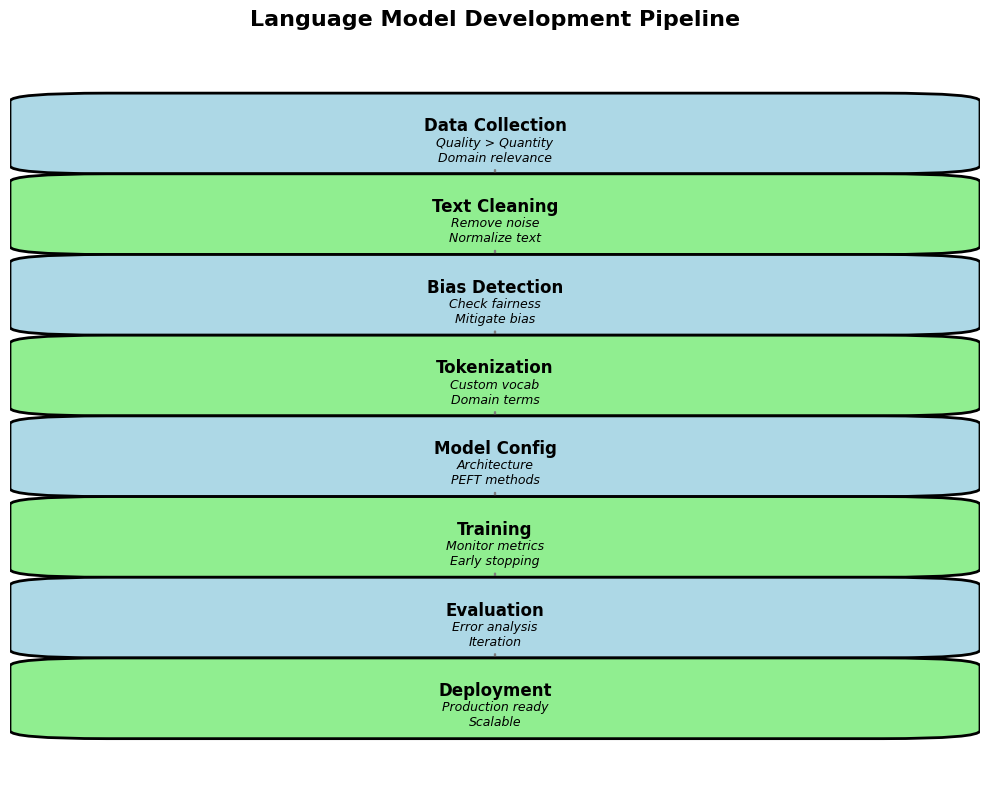

In [22]:
# Create a summary visualization
try:
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    HAS_MATPLOTLIB = True
except ImportError:
    print("⚠️ matplotlib not available - showing text-based summary instead")
    HAS_MATPLOTLIB = False

if HAS_MATPLOTLIB:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Define the pipeline stages
    stages = [
        "Data Collection",
        "Text Cleaning",
        "Bias Detection",
        "Tokenization",
        "Model Config",
        "Training",
        "Evaluation",
        "Deployment"
    ]

    # Key learnings for each stage
    learnings = [
        "Quality > Quantity\nDomain relevance",
        "Remove noise\nNormalize text",
        "Check fairness\nMitigate bias",
        "Custom vocab\nDomain terms",
        "Architecture\nPEFT methods",
        "Monitor metrics\nEarly stopping",
        "Error analysis\nIteration",
        "Production ready\nScalable"
    ]

    # Create flowchart
    y_positions = range(len(stages), 0, -1)
    x_position = 0.5

    for i, (stage, learning) in enumerate(zip(stages, learnings)):
        # Draw box
        rect = mpatches.FancyBboxPatch(
            (x_position - 0.4, y_positions[i] - 0.4),
            0.8, 0.8,
            boxstyle="round,pad=0.1",
            facecolor='lightblue' if i % 2 == 0 else 'lightgreen',
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_position, y_positions[i] + 0.1, stage, 
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax.text(x_position, y_positions[i] - 0.2, learning, 
                ha='center', va='center', fontsize=9, style='italic')
        
        # Draw arrow to next stage
        if i < len(stages) - 1:
            ax.arrow(x_position, y_positions[i] - 0.45, 0, -0.1, 
                    head_width=0.05, head_length=0.05, fc='gray', ec='gray')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(stages) + 1)
    ax.axis('off')
    ax.set_title('Language Model Development Pipeline', fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()
else:
    # Text-based summary for when matplotlib is not available
    print("\n🎯 Language Model Development Pipeline Summary")
    print("=" * 50)
    
    stages_and_learnings = [
        ("Data Collection", "Quality > Quantity, Domain relevance"),
        ("Text Cleaning", "Remove noise, Normalize text"),
        ("Bias Detection", "Check fairness, Mitigate bias"),
        ("Tokenization", "Custom vocab, Domain terms"),
        ("Model Config", "Architecture, PEFT methods"),
        ("Training", "Monitor metrics, Early stopping"),
        ("Evaluation", "Error analysis, Iteration"),
        ("Deployment", "Production ready, Scalable")
    ]
    
    for i, (stage, learning) in enumerate(stages_and_learnings, 1):
        print(f"\n{i}. {stage}")
        print(f"   → {learning}")
        if i < len(stages_and_learnings):
            print(f"   ↓")

### 📚 Key Takeaways

1. **Data Quality Drives Results** 📊
   - Clean, relevant data is more valuable than quantity
   - Domain-specific curation creates specialized models
   - Regular quality checks prevent downstream issues

2. **Efficient Processing Enables Scale** 🚀
   - Streaming handles datasets larger than memory
   - Batch processing improves throughput
   - Privacy protection is non-negotiable

3. **Modern Techniques Save Resources** 💡
   - Parameter-efficient methods (LoRA/QLoRA) democratize fine-tuning
   - Mixed precision training reduces memory usage
   - Gradient checkpointing enables larger models

4. **Monitoring Prevents Failures** 📈
   - Track multiple metrics, not just loss
   - Early stopping saves compute
   - Regular evaluation catches issues early

5. **Iteration Drives Improvement** 🔄
   - Error analysis reveals model weaknesses
   - A/B testing validates improvements
   - User feedback guides development

### 🚀 Next Steps

Ready to build your own custom language model? Here's your action plan:

1. **Identify Your Domain**: What specific area needs a custom model?
2. **Gather Quality Data**: Start collecting domain-specific texts
3. **Start Small**: Begin with a small model and dataset
4. **Iterate Quickly**: Build, test, and improve in rapid cycles
5. **Scale Gradually**: Increase size as you validate results

### 🎯 Try This

**Challenge**: Take a domain you're familiar with and:
1. List 5 unique data sources that generic models might miss
2. Identify 10 domain-specific terms that need proper tokenization
3. Design a simple evaluation metric for your use case

Remember: The best model is the one that solves your specific problem effectively!

# Create a summary visualization
try:
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    HAS_MATPLOTLIB = True
except ImportError:
    print("⚠️ matplotlib not available - skipping visualization")
    HAS_MATPLOTLIB = False

if HAS_MATPLOTLIB:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Define the pipeline stages
    stages = [
        "Data Collection",
        "Text Cleaning",
        "Bias Detection",
        "Tokenization",
        "Model Config",
        "Training",
        "Evaluation",
        "Deployment"
    ]

    # Key learnings for each stage
    learnings = [
        "Quality > Quantity\nDomain relevance",
        "Remove noise\nNormalize text",
        "Check fairness\nMitigate bias",
        "Custom vocab\nDomain terms",
        "Architecture\nPEFT methods",
        "Monitor metrics\nEarly stopping",
        "Error analysis\nIteration",
        "Production ready\nScalable"
    ]

    # Create flowchart
    y_positions = range(len(stages), 0, -1)
    x_position = 0.5

    for i, (stage, learning) in enumerate(zip(stages, learnings)):
        # Draw box
        rect = mpatches.FancyBboxPatch(
            (x_position - 0.4, y_positions[i] - 0.4),
            0.8, 0.8,
            boxstyle="round,pad=0.1",
            facecolor='lightblue' if i % 2 == 0 else 'lightgreen',
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_position, y_positions[i] + 0.1, stage, 
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax.text(x_position, y_positions[i] - 0.2, learning, 
                ha='center', va='center', fontsize=9, style='italic')
        
        # Draw arrow to next stage
        if i < len(stages) - 1:
            ax.arrow(x_position, y_positions[i] - 0.45, 0, -0.1, 
                    head_width=0.05, head_length=0.05, fc='gray', ec='gray')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(stages) + 1)
    ax.axis('off')
    ax.set_title('Language Model Development Pipeline', fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()
else:
    # Text-based summary for when matplotlib is not available
    print("\n🎯 Language Model Development Pipeline Summary")
    print("=" * 50)
    
    stages = [
        ("Data Collection", "Quality > Quantity, Domain relevance"),
        ("Text Cleaning", "Remove noise, Normalize text"),
        ("Bias Detection", "Check fairness, Mitigate bias"),
        ("Tokenization", "Custom vocab, Domain terms"),
        ("Model Config", "Architecture, PEFT methods"),
        ("Training", "Monitor metrics, Early stopping"),
        ("Evaluation", "Error analysis, Iteration"),
        ("Deployment", "Production ready, Scalable")
    ]
    
    for i, (stage, learning) in enumerate(stages, 1):
        print(f"\n{i}. {stage}")
        print(f"   → {learning}")

## 🔧 Troubleshooting Guide

### Common Issues and Solutions

#### 1. ⚡ Accelerate Version Compatibility

If you encounter issues with model initialization or training:

```bash
# Check current version
poetry show accelerate

# Update to required version
poetry add accelerate@^0.26.0

# Or with pip
pip install accelerate>=0.26.0
```

**Symptoms**: 
- ImportError with accelerate
- Model initialization failures
- Training configuration errors

#### 2. 🔑 API Key Configuration Errors

**Issue**: "API key not found" or "placeholder value" errors

**Solution**:
1. Create `.env` file from template:
   ```bash
   cp .env.example .env
   ```

2. Edit `.env` and add actual API keys:
   ```
   OPENAI_API_KEY=sk-...your-actual-key...
   ANTHROPIC_API_KEY=sk-ant-...your-actual-key...
   HUGGINGFACE_TOKEN=hf_...your-actual-token...
   ```

3. Verify keys are loaded:
   ```python
   import os
   from dotenv import load_dotenv
   load_dotenv(override=True)  # Force reload
   
   # Check if loaded correctly
   print(f"OpenAI key starts with: {os.getenv('OPENAI_API_KEY', 'Not set')[:10]}...")
   ```

4. Restart kernel after updating `.env`

#### 3. 🖥️ Bitsandbytes GPU Warning on macOS

**Issue**: "GPU not supported" warning when importing bitsandbytes

**Solution**:
```python
# Suppress the warning
import os
os.environ["BITSANDBYTES_NOWELCOME"] = "1"

# Note: Bitsandbytes will fallback to CPU on macOS
# This is expected behavior - Metal/MPS is not yet supported
```

#### 4. 💾 CUDA Out of Memory Errors

**Symptoms**: `RuntimeError: CUDA out of memory`

**Solutions**:
```python
# 1. Reduce batch size
training_args.per_device_train_batch_size = 1
training_args.per_device_eval_batch_size = 1

# 2. Enable gradient accumulation
training_args.gradient_accumulation_steps = 8

# 3. Use mixed precision
training_args.fp16 = True  # or bf16=True for newer GPUs

# 4. Clear GPU cache
import torch
torch.cuda.empty_cache()

# 5. Use gradient checkpointing
model.gradient_checkpointing_enable()

# 6. Use parameter-efficient methods
from peft import LoraConfig, get_peft_model
peft_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
)
model = get_peft_model(model, peft_config)
```

#### 5. 📦 Import Errors

**Issue**: Module not found errors

**Solutions**:
```bash
# Full reinstall with Poetry
poetry install

# Or specific package
poetry add transformers@^4.36.0
poetry add datasets@^2.14.0
poetry add peft@^0.7.0

# Verify installation
poetry show

# If using pip instead
pip install -r requirements.txt
```

#### 6. 🌐 Dataset Loading Errors

**Issue**: Connection errors or timeouts when loading datasets

**Solutions**:
```python
# 1. Use local cache
from datasets import load_dataset
dataset = load_dataset("dataset_name", cache_dir="./cache")

# 2. Set timeout
import requests
from datasets import config
config.DATASETS_DOWNLOAD_TIMEOUT = 300  # 5 minutes

# 3. Use offline mode
os.environ["HF_DATASETS_OFFLINE"] = "1"

# 4. Load from local files
dataset = Dataset.from_json("local_data.json")
```

#### 7. 🔄 Training Not Converging

**Symptoms**: Loss stays constant or increases

**Diagnostic Steps**:
```python
# 1. Check learning rate
print(f"Learning rate: {trainer.args.learning_rate}")
# Try: 5e-5, 2e-5, 1e-5, 5e-6

# 2. Verify data is loaded correctly
print(f"Train samples: {len(train_dataset)}")
print(f"Sample: {train_dataset[0]}")

# 3. Check model outputs change
before = model(input_ids).logits
optimizer.step()
after = model(input_ids).logits
print(f"Outputs changed: {not torch.allclose(before, after)}")

# 4. Enable logging
training_args.logging_steps = 1
training_args.logging_first_step = True
```

### 🏃 Running Examples Outside Notebook

The project includes task automation for easy execution:

```bash
# Setup environment (one-time)
task setup

# Run all examples
task run

# Run specific components
task run-prompt-engineering
task run-few-shot-learning
task run-chain-of-thought

# Run tests
task test

# Format code
task format

# Clean generated files
task clean
```

### 📚 Additional Resources

1. **Project Documentation**: See `docs/article11.md` for comprehensive guide
2. **Hugging Face Forums**: https://discuss.huggingface.co/
3. **PyTorch Forums**: https://discuss.pytorch.org/
4. **Accelerate Documentation**: https://huggingface.co/docs/accelerate/

### 🆘 Getting Help

If you encounter issues not covered here:

1. Check error messages carefully - they often contain the solution
2. Search for the error message online
3. Create a minimal reproducible example
4. Check project issues on GitHub
5. Ask on relevant forums with:
   - Your environment details (OS, Python version, package versions)
   - Complete error traceback
   - Minimal code to reproduce

Remember: Most errors have been encountered before - the solution is usually just a search away!